In [66]:
from langgraph.graph import StateGraph,START,END
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from typing import TypedDict, Annotated,Literal
from pydantic import BaseModel, Field

In [67]:
load_dotenv()

True

In [68]:
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [69]:
class Sentiment(BaseModel):
    sentiment: Literal["positive","negative"] = Field(description="sentiment of the review")

llm = model.with_structured_output(Sentiment)

class Daignosis(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')
llm1 =model.with_structured_output(Daignosis)


In [70]:
class ReviewState(TypedDict):

    review : str
    sentiment : Literal["positive",'negative']
    daignosis: str
    response: str
    

In [77]:
def sentiment(state:ReviewState):
    prompt = f"give the sentiment in positive or negative from the provided review /n {state['review']}"
    output = llm.invoke(prompt)

    return {"sentiment":output.sentiment}

def positive_response(state:ReviewState):
    prompt = f"""Write a warm thank-you message in response to this review \n{state['review']}"\n
Also, kindly ask the user to leave feedback on our website"""

    response = model.invoke("prompt")
    return {"response":response.content}

def negative_response(state:ReviewState):
    prompt = f"""You are a support assistant.  
    The user had a {state['daignosis']['issue_type']} issue, sounded {state['daignosis']['tone']}, and marked urgency as {state['daignosis']['urgency']}.  
    Write an empathetic, helpful resolution message."""
    response = model.invoke("prompt")
    return {"response":response.content}

def daignosis(state:ReviewState):
    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n Return issue_type, tone, and urgency."""
    daignosis = llm1.invoke("prompt")
    return {"daignosis":daignosis.model_dump()}
    

def check_condition(state:ReviewState) -> Literal["positive_response","daignosis"]:

    if state["sentiment"] == "positive":
        return "positive_response"
    else:
        return "daignosis"


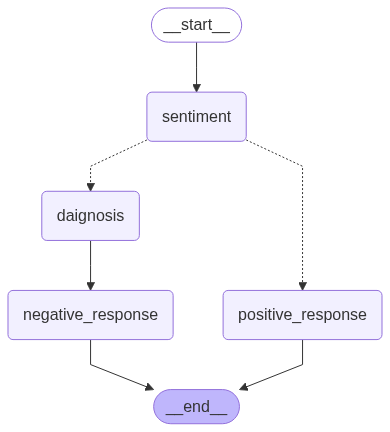

In [78]:
graph = StateGraph(ReviewState)

graph.add_node("sentiment",sentiment)
graph.add_node("daignosis",daignosis)
graph.add_node("positive_response",positive_response)
graph.add_node("negative_response",negative_response)

graph.add_edge(START,"sentiment")
graph.add_conditional_edges("sentiment",check_condition)
graph.add_edge("positive_response",END)
graph.add_edge("daignosis","negative_response")
graph.add_edge("negative_response",END)

workflow = graph.compile()
graph.compile()


In [79]:
initial_state = {"review":"""I’ve been using this app for about a month now, and I must say, the user interface is incredibly clean and intuitive.  
Everything is exactly where you’d expect it to be. It’s rare to find something that just works without needing a tutorial.  
Great job to the design team!
"""}
final_state= workflow.invoke(initial_state)
print(final_state)

{'review': 'I’ve been using this app for about a month now, and I must say, the user interface is incredibly clean and intuitive.  \nEverything is exactly where you’d expect it to be. It’s rare to find something that just works without needing a tutorial.  \nGreat job to the design team!\n', 'sentiment': 'positive', 'response': 'Okay, "prompt" is a very broad term! To give you the best possible prompt, I need a little more information.\n\nAre you looking for:\n\n1.  **A prompt for *me* to respond to?** (e.g., "Tell me a story about a talking teapot," or "Explain quantum physics in simple terms.")\n2.  **A prompt for *you* to use?** (e.g., "Give me a creative writing prompt," or "Give me a journaling prompt.")\n3.  **An example of what a good prompt looks like?**\n4.  **A prompt on a specific topic?** (e.g., sci-fi, history, self-improvement, coding, a specific game, etc.)\n5.  **A prompt of a certain type?** (e.g., a question, a scenario, a challenge, an idea generator, a list.)\n\nPle